<a href="https://colab.research.google.com/github/DanTheStrongworded/Analytics-Projects/blob/main/Portfolio_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Description**

This project focuses on analyzing orders and sessions and discovering corresponding insights. The analyzed dataset covers mainly non-registered customers' sessions to concentrate on the online store's sales.

**Contents**:

- Dataset Description (general information about the analyzed dataset):
- General Analytics (top countries, continents, products, devices, media, and other information about the biggest sales and order rates);
- Dynamics Analysis (sales and order rates are observed in terms of order datetimes to look at how they fluctuated across time);
-Pivot Tables
- Statistical Analysis of Relations (correlations between sales by continents, media);
- Statistical Analysis of Group Differences (revealing differences between sales among registered and non-registered customers, different media);
- Tableau Visualization (link to the dashboard on Tableau Public);
- What's Been Discovered (general conclusions about what's been revealed).

In [1]:
!pip install --quiet google-cloud-bigquery pandas

from google.cloud import bigquery
import pandas as pd

from google.colab import auth
auth.authenticate_user()

project_id = 'data-analytics-mate'
client = bigquery.Client(project=project_id)

query = """
    WITH
  session_info AS (
  SELECT
    s.ga_session_id,
    s.date AS order_date,
    sp.continent AS continent,
    sp.country AS country,
    sp.device,
    sp.browser,
    sp.mobile_model_name,
    sp.operating_system,
    sp.language,
    sp.channel,
    sp.medium,
    p.category,
    p.name,
    p.price,
    p.short_description
  FROM
    `DA.session` s
  INNER JOIN
    `DA.session_params` sp
  ON
    s.ga_session_id = sp.ga_session_id
  FULL JOIN
    `DA.order` o
  ON
    s.ga_session_id = o.ga_session_id
  LEFT JOIN
    `DA.product` p
  ON
    o.item_id = p.item_id
  GROUP BY
    s.date,
    s.ga_session_id,
    sp.continent,
    sp.country,
    sp.device,
    sp.browser,
    sp.mobile_model_name,
    sp.operating_system,
    sp.language,
    sp.channel,
    sp.medium,
    p.category,
    p.name,
    p.price,
    p.short_description ),
  account_info AS (
  SELECT
    ac.id AS account_id,
    s.ga_session_id,
    ac.is_verified,
    ac.is_unsubscribed
  FROM
    `DA.account` ac
  INNER JOIN
    `DA.account_session` acs
  ON
    ac.id = acs.account_id
  LEFT JOIN
    `DA.session` s
  ON
    acs.ga_session_id = s.ga_session_id
  GROUP BY
    ac.is_verified,
    ac.id,
    ac.is_unsubscribed,
    s.ga_session_id )
SELECT
  session_info.order_date,
  session_info.ga_session_id,
  session_info.continent,
  session_info.country,
  session_info.device,
  session_info.browser,
  session_info.mobile_model_name,
  session_info.operating_system,
  session_info.language,
  session_info.channel,
  session_info.medium,
  session_info.category,
  session_info.name,
  session_info.price,
  session_info.short_description,
  account_info.account_id,
  account_info.is_verified,
  account_info.is_unsubscribed
FROM
  session_info
FULL JOIN
  account_info
ON
  session_info.ga_session_id = account_info.ga_session_id;
"""

order_df = client.query(query).to_dataframe()
print(order_df.head())

   order_date  ga_session_id  continent    country   device browser  \
0  2020-12-08     4911003483  (not set)  (not set)  desktop  Chrome   
1  2021-01-30      605574233  (not set)  (not set)  desktop  Safari   
2  2020-11-16     5644249991       Asia  Singapore  desktop    Edge   
3  2021-01-31      561694651       Asia     Taiwan  desktop  Chrome   
4  2021-01-21     3400245358       Asia      India  desktop  Chrome   

  mobile_model_name operating_system language         channel   medium  \
0            Safari              Web     None     Paid Search  <Other>   
1            Safari              Web     None  Organic Search  organic   
2              Edge              Web     None  Organic Search  organic   
3            Chrome              Web     None          Direct   (none)   
4            Chrome              Web    en-us          Direct   (none)   

  category  name  price short_description  account_id  is_verified  \
0     None  None    NaN              None        <NA>     

#**Dataset Description**

In [ ]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   channel            349545 non-null  object 
 10  medium             349545 non-null  object 
 11  category           33538 non-null   object 
 12  name               33538 non-null   object 
 13  price              33538 non-null   float64
 14  short_description  33538 non-null   object 
 15  account_id         27945 non-null   Int64  
 16  is

In [ ]:
unique_sessions = order_df['ga_session_id'].nunique()
print(f"There are {unique_sessions} unique sessions in the DataFrame.")

There are 349545 unique sessions in the DataFrame.


In [ ]:
min_time = order_df['order_date'].min()
max_time = order_df['order_date'].max()
print(f"The DataFrame concerns the period from {min_time} to {max_time}")

The DataFrame concerns the period from 2020-11-01 to 2021-01-31


In [ ]:
missed_num = order_df.isna().sum()
percent = (order_df.isna().sum() / order_df.shape[0]) * 100

print(f"Number of missed values:\n{missed_num} \n")
print(f"Percent of missed values:\n{percent}")


Number of missed values:
order_date                0
ga_session_id             0
continent                 0
country                   0
device                    0
browser                   0
mobile_model_name         0
operating_system          0
language             114266
channel                   0
medium                    0
category             316007
name                 316007
price                316007
short_description    316007
account_id           321600
is_verified          321600
is_unsubscribed      321600
dtype: int64 

Percent of missed values:
order_date            0.000000
ga_session_id         0.000000
continent             0.000000
country               0.000000
device                0.000000
browser               0.000000
mobile_model_name     0.000000
operating_system      0.000000
language             32.689925
channel               0.000000
medium                0.000000
category             90.405241
name                 90.405241
price                90.405

Columns with the most missed values are *category*, *name*, *price*, *short_description*, *account_id*, *is_verified*, and *is_unsubscribed*. The smaller percent is in *language* column. The probable reason for this may be that customers make orders without registration.

#**General Analytics**

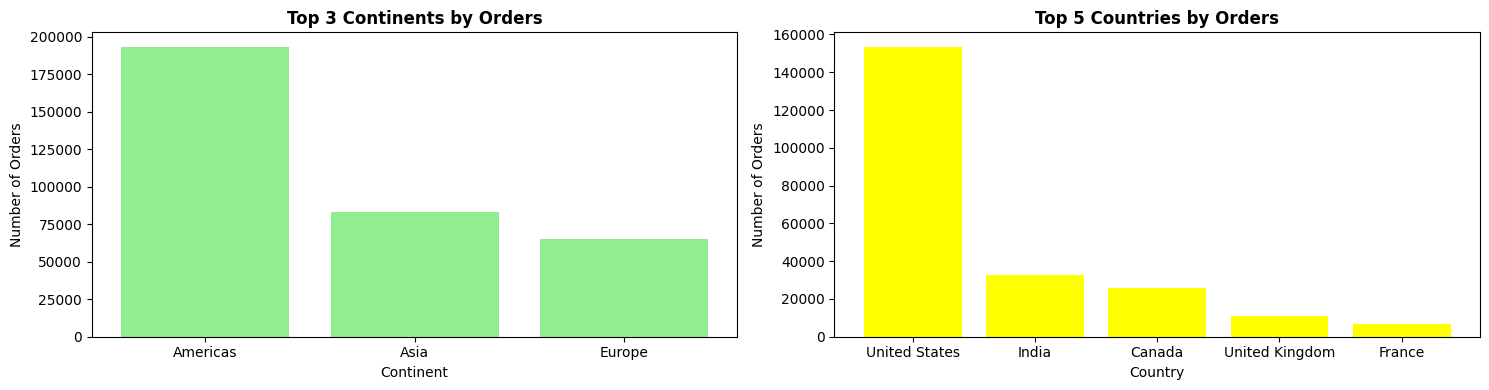

In [ ]:
import matplotlib.pyplot as plt

# Aggregating and selecting the top 3 continents
top_continents = (
    order_df.groupby("continent")["ga_session_id"]
    .count()
    .sort_values(ascending=False)
    .head(3)
)

# Aggregating and selecting the top 5 countries
top_countries = (
    order_df.groupby("country")["ga_session_id"]
    .count()
    .sort_values(ascending=False)
    .head(5)
)

# Creating the bar charts
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Plot for top 3 continents
ax[0].bar(top_continents.index, top_continents.values, color="lightgreen")
ax[0].set_title("Top 3 Continents by Orders", fontweight="semibold")
ax[0].set_xlabel("Continent")
ax[0].set_ylabel("Number of Orders")

# Plot for top 5 countries
ax[1].bar(top_countries.index, top_countries.values, color="yellow")
ax[1].set_title("Top 5 Countries by Orders", fontweight="semibold")
ax[1].set_xlabel("Country")
ax[1].set_ylabel("Number of Orders")

plt.tight_layout()
plt.show()


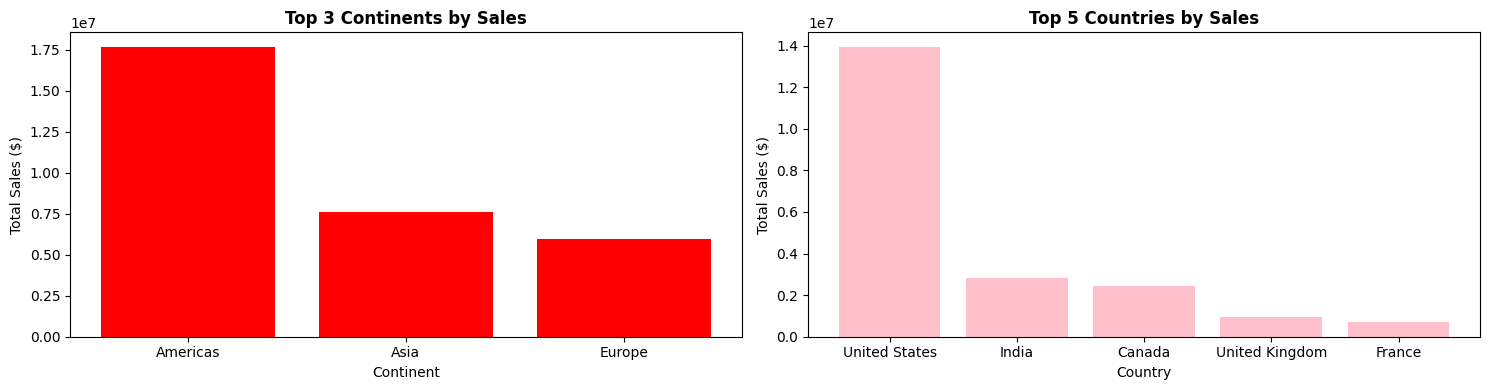

In [ ]:
#Filling price column with median values to visualize
order_df["price"].fillna(order_df["price"].median())

# Aggregating and selecting the top 3 continents
top_continents = (
    order_df.groupby("continent")["price"]
    .sum()
    .sort_values(ascending=False)
    .head(3)
)

# Aggregating and selecting the top 5 countries
top_countries = (
    order_df.groupby("country")["price"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

# Creating the bar charts
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# Plot for top 3 continents
ax[0].bar(top_continents.index, top_continents.values, color="red")
ax[0].set_title("Top 3 Continents by Sales", fontweight="semibold")
ax[0].set_xlabel("Continent")
ax[0].set_ylabel("Total Sales ($)")

# Plot for top 5 countries
ax[1].bar(top_countries.index, top_countries.values, color="pink")
ax[1].set_title("Top 5 Countries by Sales", fontweight="semibold")
ax[1].set_xlabel("Country")
ax[1].set_ylabel("Total Sales ($)")

plt.tight_layout()
plt.show()

There is no difference between rating by number of orders and sales (price).

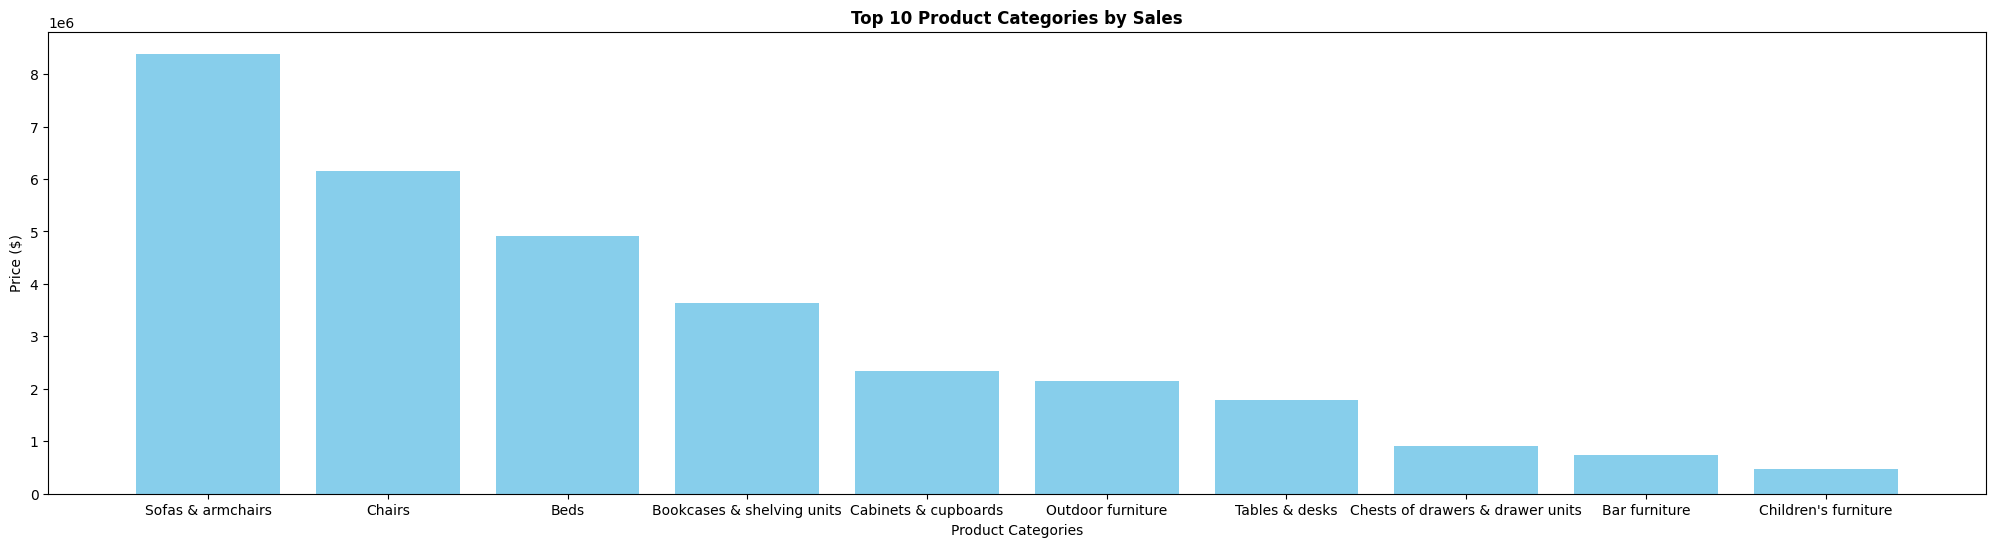

In [ ]:
#Filling price column with median values to visualize
order_df["price"].fillna(order_df["price"].median())

# Aggregating and selecting the top 3 continents
top_products = (
    order_df.groupby("category")["price"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
plt.figure(figsize=(25,6))
plt.bar(top_products.index, top_products.values, color="skyblue")
plt.title("Top 10 Product Categories by Sales", fontweight="semibold")
plt.xlabel("Product Categories")
plt.ylabel("Price ($)")
plt.show()

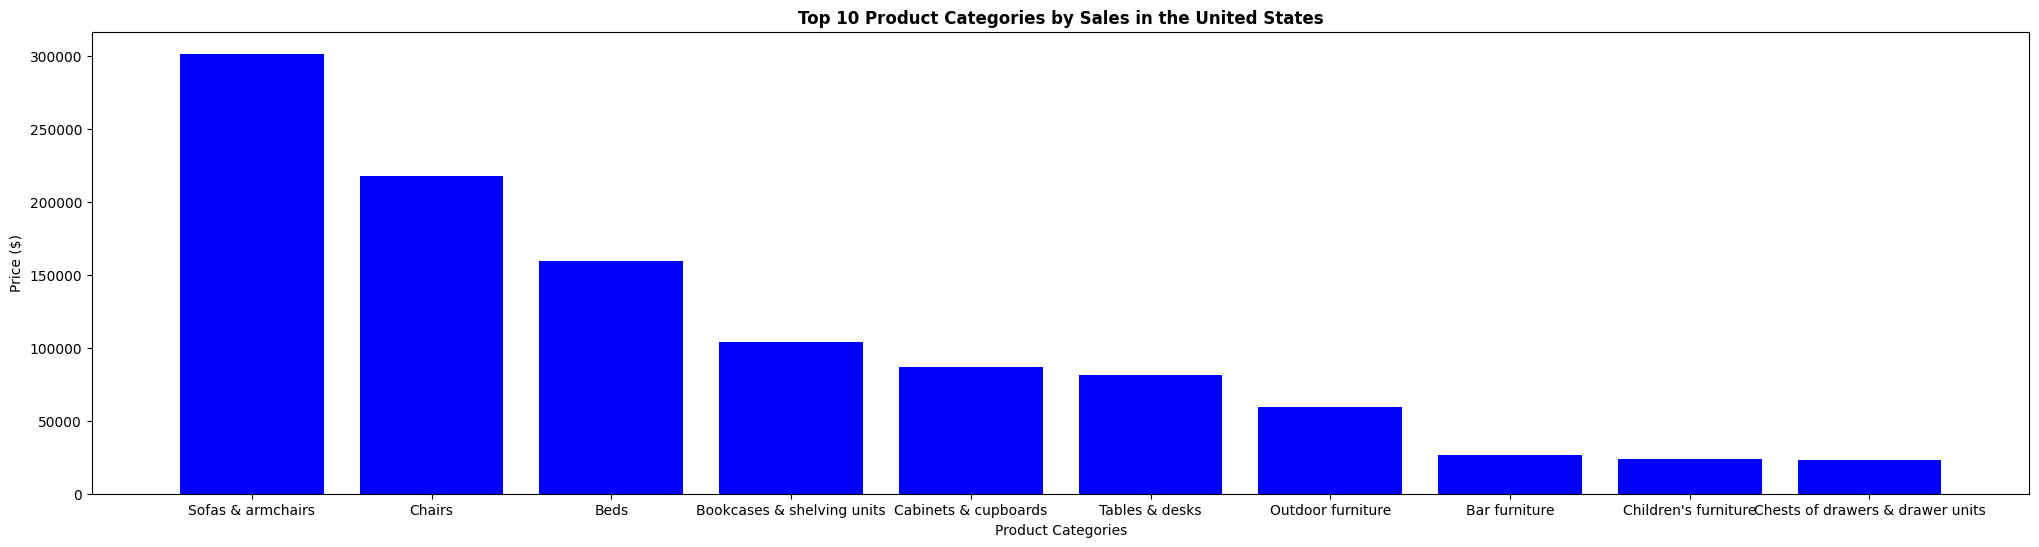

In [5]:
#Filling price column with median values to visualize
order_df["price"].fillna(order_df["price"].median())

# Aggregating and selecting the top 3 continents
top_products = (
    order_df[order_df["country"] == "United States"].groupby("category")["price"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
plt.figure(figsize=(25,6))
plt.bar(top_products.index, top_products.values, color="blue")
plt.title("Top 10 Product Categories by Sales in the United States", fontweight="semibold")
plt.xlabel("Product Categories")
plt.ylabel("Price ($)")
plt.show()

The general situation does not differ from the situation in the United States.

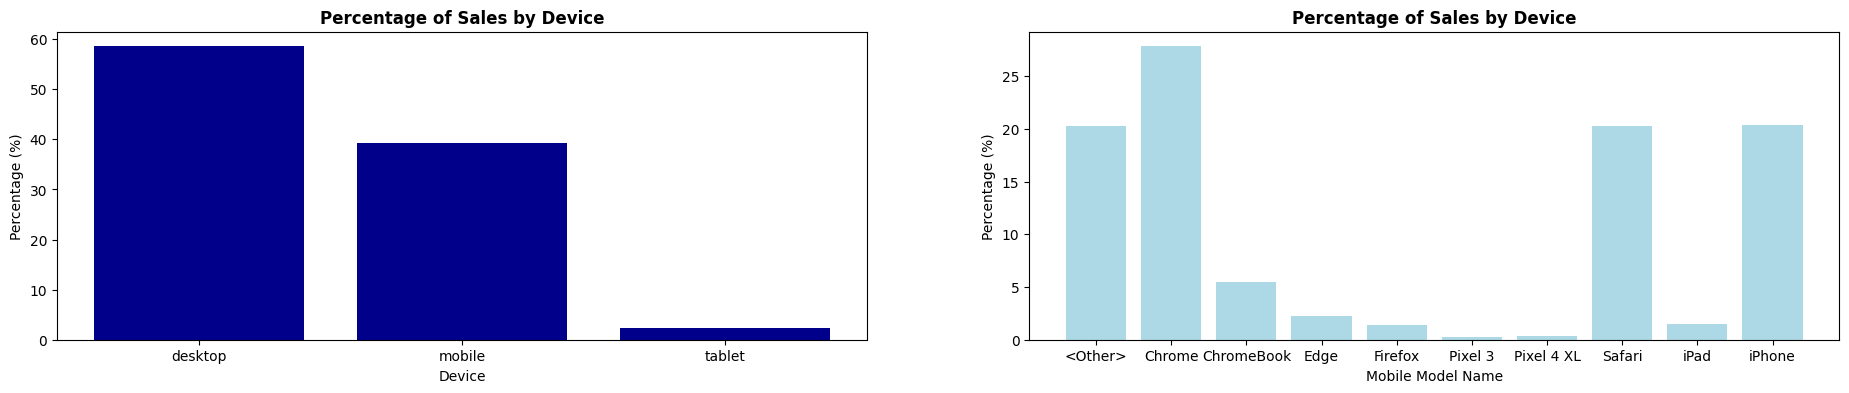

In [ ]:
# Filling the "price" column with median values to handle missing data
order_df["price"] = order_df["price"].fillna(order_df["price"].median())

# Calculating total sales
total_sales = order_df["price"].sum()

# Calculating sales for devices
device_sales = (
    order_df.groupby("device")["price"]
    .sum()
)

# Calculating sales for mobile model names
mobile_model_sales = (
    order_df.groupby("mobile_model_name")["price"]
    .sum()
)

# Calculating the percentage of device sales
device_sales_percentage = (device_sales / total_sales) * 100

# Calculating the percentage of mobile model sales
model_sales_percentage = (mobile_model_sales / total_sales) * 100

# Creating the bar charts
fig, ax = plt.subplots(1, 2, figsize=(23, 4))
ax[0].bar(device_sales_percentage.index, device_sales_percentage.values, color="darkblue")
ax[0].set_title("Percentage of Sales by Device", fontweight="semibold")
ax[0].set_xlabel("Device")
ax[0].set_ylabel("Percentage (%)")

ax[1].bar(model_sales_percentage.index, model_sales_percentage.values, color="lightblue")
ax[1].set_title("Percentage of Sales by Device", fontweight="semibold")
ax[1].set_xlabel("Mobile Model Name")
ax[1].set_ylabel("Percentage (%)")
plt.show()

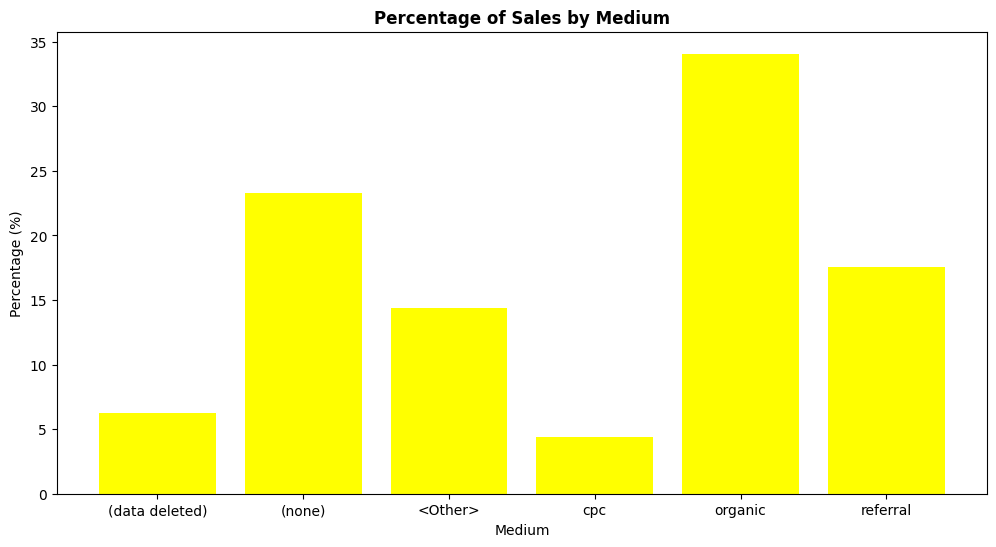

In [ ]:
# Filling the "price" column with median values to handle missing data
order_df["price"] = order_df["price"].fillna(order_df["price"].median())

# Calculating total sales
total_sales = order_df["price"].sum()

# Calculating sales for devices
medium_sales = (
    order_df.groupby("medium")["price"]
    .sum()
)
# Calculating the percentage of device sales
medium_sales_percentage = (medium_sales / total_sales) * 100

plt.figure(figsize=(12,6))
plt.bar(medium_sales_percentage.index, medium_sales_percentage.values, color="yellow")
plt.title("Percentage of Sales by Medium", fontweight="semibold")
plt.xlabel("Medium")
plt.ylabel("Percentage (%)")
plt.show()

In [ ]:
# Removing missing values from account_id and is_verified columns
order_df.dropna(subset=["account_id", "is_verified"], inplace=True)

# Calculating total number of accounts and number of verified accounts
total_accounts = order_df["account_id"].count()
total_verified = order_df[order_df["is_verified"] == 1]["account_id"].count()

# Calculating the percentage of verified accounts
verified_accounts_percentage = (total_verified / total_accounts) * 100

print(f"{verified_accounts_percentage.round(2)}% registered customers verified their email addresses.")

67.78% registered customers verified their email addresses.


As there are many missing values in the accound_id and is_verified columns, the above calculations were made relying on available data.

In [ ]:
# Removing missing values from account_id and is_verified columns
order_df.dropna(subset=["account_id", "is_unsubscribed"], inplace=True)

# Calculating total number of accounts and number of verified accounts
total_accounts = order_df["account_id"].count()
total_unsubscribed = order_df[order_df["is_unsubscribed"] == 1]["account_id"].count()

# Calculating the percentage of verified accounts
unsubscribed_percentage = (total_unsubscribed / total_accounts) * 100

print(f"{unsubscribed_percentage.round(2)}% registered customers unsubscribed from news dissemination.")

16.94% registered customers unsubscribed from news dissemination.


As there are many missing values in the accound_id and is_unsubscribed columns, the above calculations were made relying on available data.

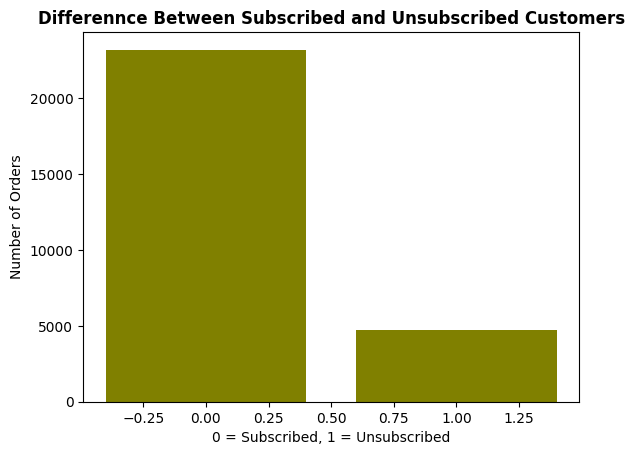

In [4]:
import matplotlib.pyplot as plt

order_df.dropna(subset=["account_id", "is_unsubscribed"], inplace=True)
# Aggregating and selecting the subscribed and unsubscribed customers
orders_sub_unsub = (
    order_df.groupby("is_unsubscribed")["ga_session_id"]
    .count()
    .sort_values()
)

plt.bar(orders_sub_unsub.index, orders_sub_unsub.values, color="olive")
plt.title("Differennce Between Subscribed and Unsubscribed Customers", fontweight="semibold")
plt.xlabel("0 = Subscribed, 1 = Unsubscribed")
plt.ylabel("Number of Orders")
plt.show()

The barplot demonstrates that subscribed customers make orders more frequently than unsubscribed ones.

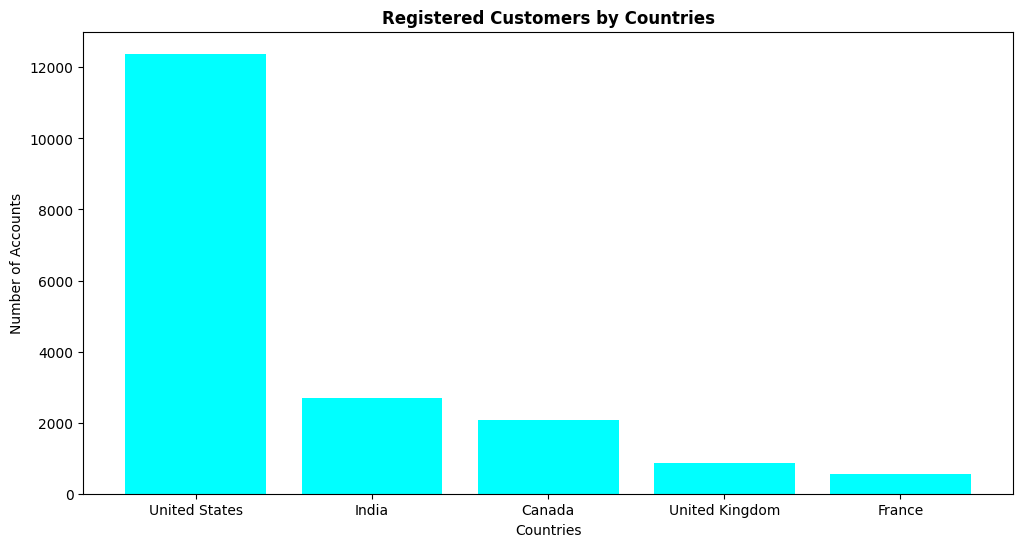

In [ ]:
# Aggregating and selecting countries and registered customers
countries_accounts = (
    order_df.groupby("country")["account_id"]
    .count()
    .sort_values(ascending=False)
    .head(5)
)

plt.figure(figsize=(12,6))
plt.bar(countries_accounts.index, countries_accounts.values, color="cyan")
plt.title("Registered Customers by Countries", fontweight="semibold")
plt.xlabel("Countries")
plt.ylabel("Number of Accounts")
plt.show()

The biggest number of registered customers (with accounts) come from the *United States*. India falls behind significantly. The rest of distribution is more or less even.

#**Dynamics Analysis**

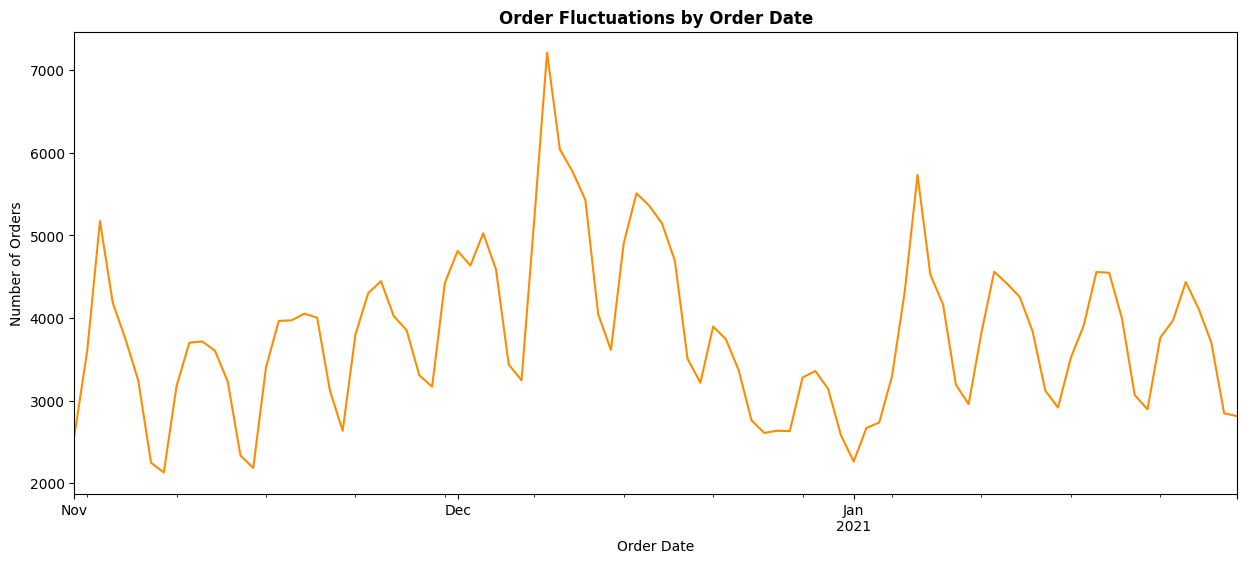

In [ ]:
import matplotlib.pyplot as plt

#Group dates by number of orders
order_trend = (
    order_df.groupby("order_date", observed=False)["ga_session_id"]
    .count()
    .sort_index()
)

#Create a line plot visualizing order trends
plt.figure(figsize=(15,6))
order_trend.plot(kind="line", color="darkorange")
plt.title("Order Fluctuations by Order Date", fontweight="semibold")
plt.xlabel("Order Date")
plt.ylabel("Number of Orders")
plt.show()

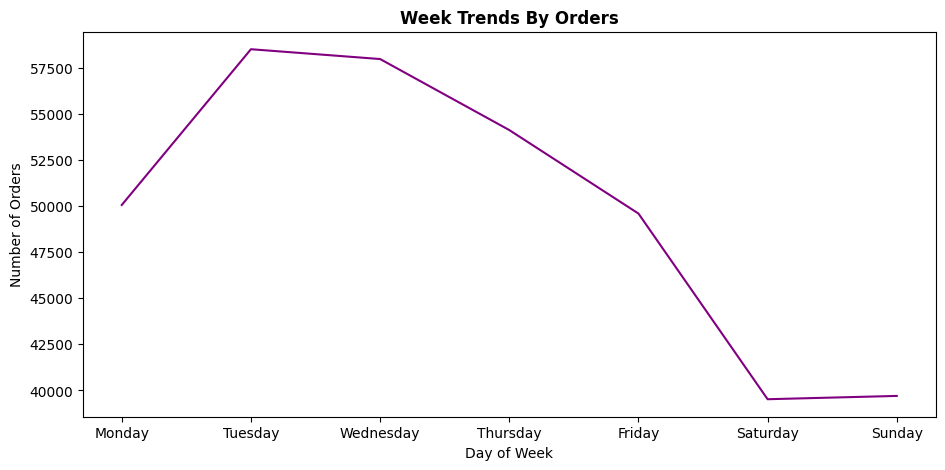

In [ ]:
#Set day of week format
order_df["order_date"] = pd.to_datetime(order_df["order_date"])
order_df["day_of_week"] = order_df["order_date"].dt.day_name()

# Define the correct order of days
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Calculate daily sales sum and mean, and align with day order
daily_orders = order_df.groupby("day_of_week")["ga_session_id"].count().reindex(days_order)

#Create a line plot visualizing order week trends
plt.figure(figsize=(11,5))
daily_orders.plot(kind="line", color="purple")
plt.title("Week Trends By Orders", fontweight="semibold")
plt.xlabel("Day of Week")
plt.ylabel("Number of Orders")
plt.show()

In [ ]:
order_df["continent"].unique()

array(['(not set)', 'Asia', 'Africa', 'Europe', 'Oceania', 'Americas'],
      dtype=object)

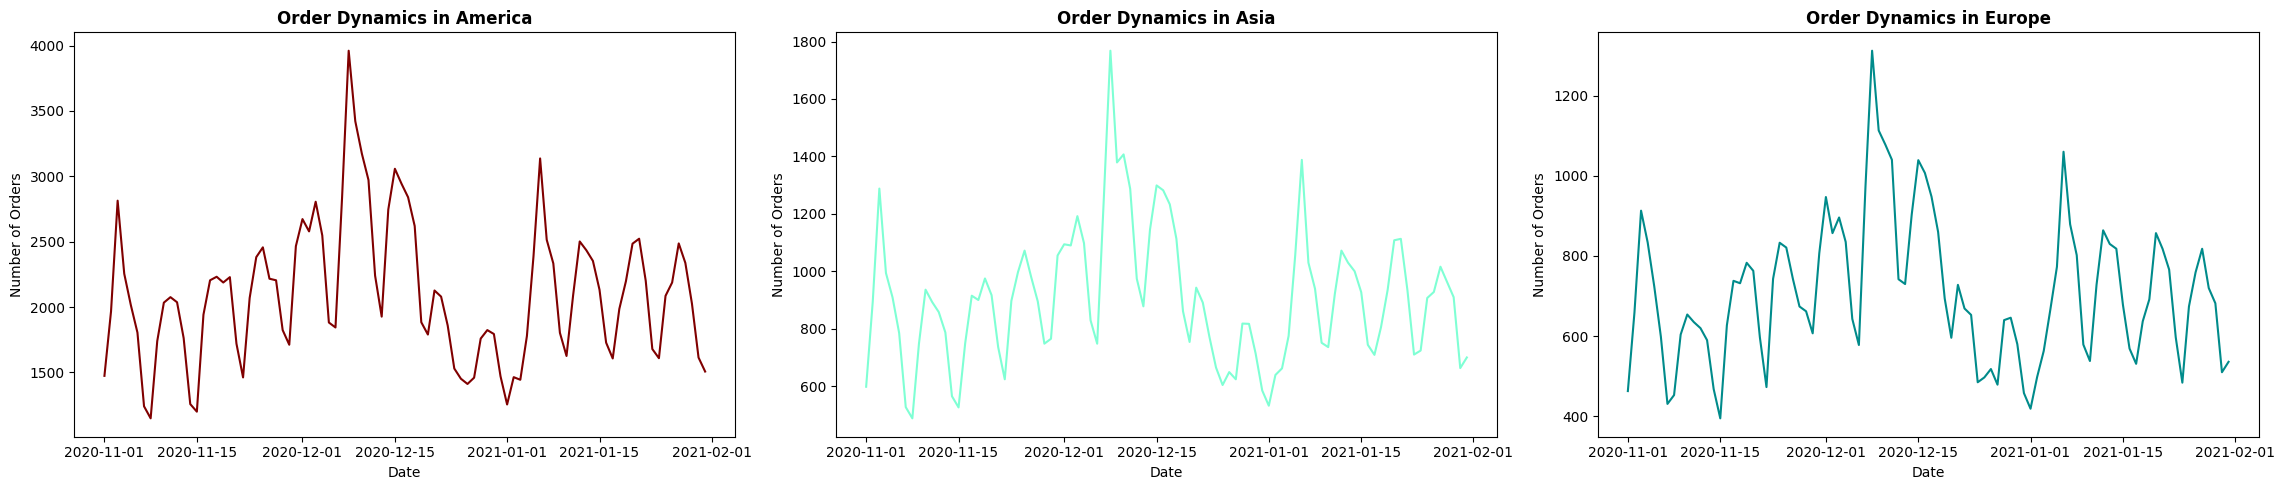

In [ ]:
#Sort orders by America continent
america_orders = (
    order_df[order_df["continent"] == "Americas"].groupby("order_date")["ga_session_id"]
    .count()
)

#Sort orders by Asia continent
asia_orders = (
    order_df[order_df["continent"] == "Asia"].groupby("order_date")["ga_session_id"]
    .count()
)

#Sort orders by Europe continent
europe_orders = (
    order_df[order_df["continent"] == "Europe"].groupby("order_date")["ga_session_id"]
    .count()
)

#Create corresponding line plots
fig, ax = plt.subplots(1, 3, figsize=(23, 5))
ax[0].plot(america_orders.index, america_orders.values, color="maroon")
ax[0].set_title("Order Dynamics in America", fontweight="semibold")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Number of Orders")

ax[1].plot(asia_orders.index, asia_orders.values, color="aquamarine")
ax[1].set_title("Order Dynamics in Asia", fontweight="semibold")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Number of Orders")

ax[2].plot(europe_orders.index, europe_orders.values, color="darkcyan")
ax[2].set_title("Order Dynamics in Europe", fontweight="semibold")
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Number of Orders")

plt.tight_layout()
plt.show()

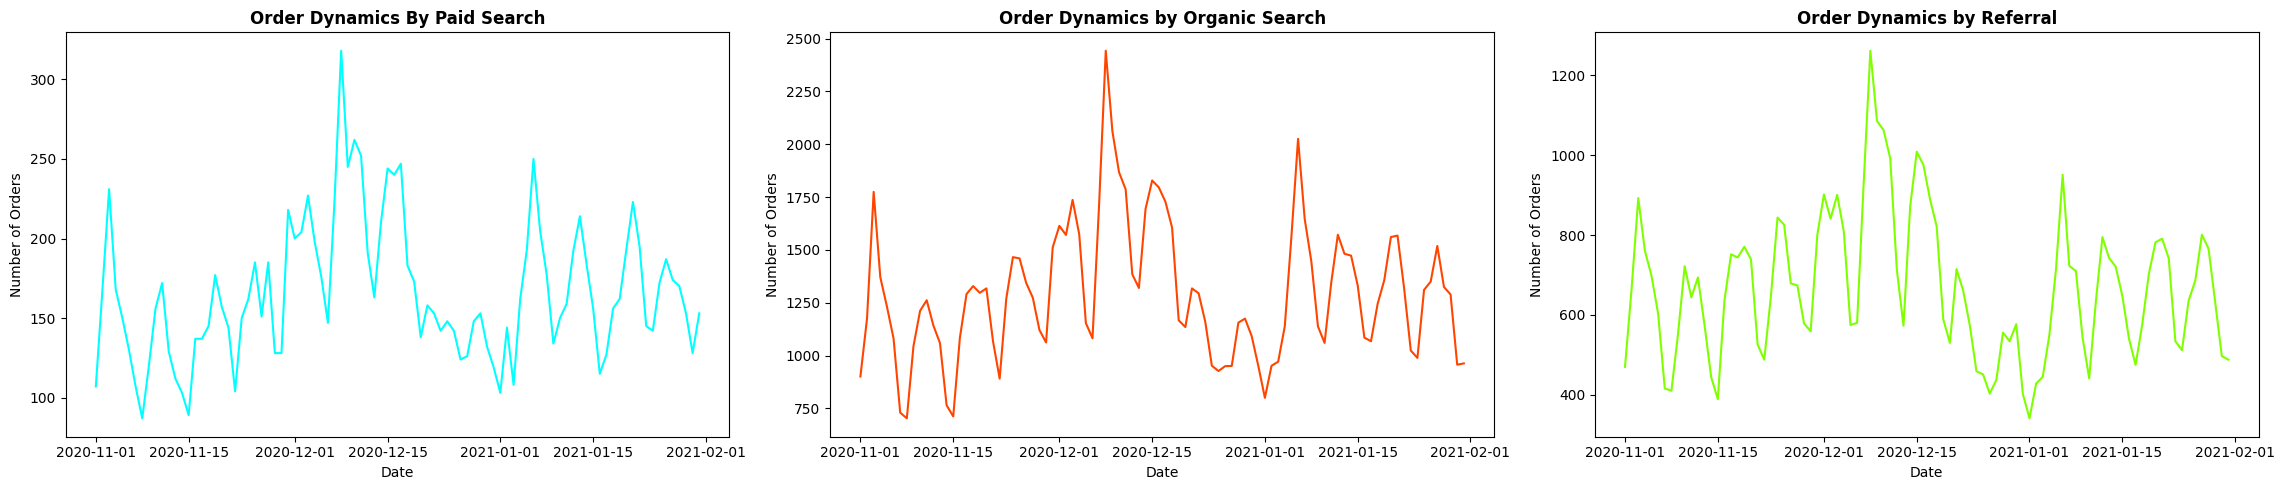

In [ ]:
#Sort orders by cpc medium
cpc_orders = (
    order_df[order_df["medium"] == "cpc"].groupby("order_date")["ga_session_id"]
    .count()
)

#Sort orders by organic medium
organic_orders = (
    order_df[order_df["medium"] == "organic"].groupby("order_date")["ga_session_id"]
    .count()
)

#Sort orders by referral medium
referral_orders = (
    order_df[order_df["medium"] == "referral"].groupby("order_date")["ga_session_id"]
    .count()
)

#Create corresponding line plots
fig, ax = plt.subplots(1, 3, figsize=(23, 5))
ax[0].plot(cpc_orders.index, cpc_orders.values, color="aqua")
ax[0].set_title("Order Dynamics By Paid Search", fontweight="semibold")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Number of Orders")

ax[1].plot(organic_orders.index, organic_orders.values, color="orangered")
ax[1].set_title("Order Dynamics by Organic Search", fontweight="semibold")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Number of Orders")

ax[2].plot(referral_orders.index, referral_orders.values, color="chartreuse")
ax[2].set_title("Order Dynamics by Referral", fontweight="semibold")
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Number of Orders")

plt.tight_layout()
plt.show()

In [ ]:
order_df["device"].unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

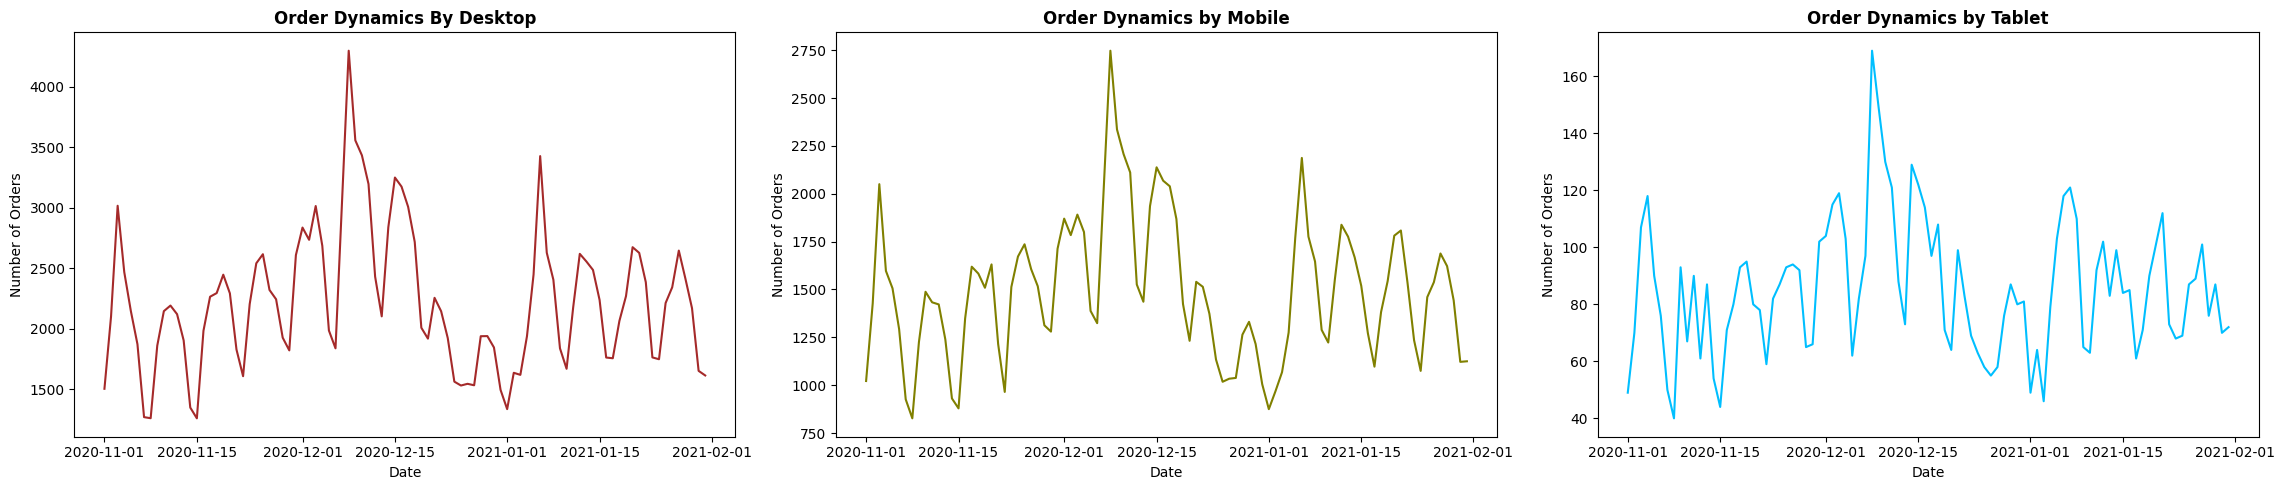

In [ ]:
#Sort orders by desktop
desktop_orders = (
    order_df[order_df["device"] == "desktop"].groupby("order_date")["ga_session_id"]
    .count()
)

#Sort orders by mobile
mobile_orders = (
    order_df[order_df["device"] == "mobile"].groupby("order_date")["ga_session_id"]
    .count()
)

#Sort orders by tablet
tablet_orders = (
    order_df[order_df["device"] == "tablet"].groupby("order_date")["ga_session_id"]
    .count()
)

#Create corresponding line plots
fig, ax = plt.subplots(1, 3, figsize=(23, 5))
ax[0].plot(desktop_orders.index, desktop_orders.values, color="brown")
ax[0].set_title("Order Dynamics By Desktop", fontweight="semibold")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Number of Orders")

ax[1].plot(mobile_orders.index, mobile_orders.values, color="olive")
ax[1].set_title("Order Dynamics by Mobile", fontweight="semibold")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Number of Orders")

ax[2].plot(tablet_orders.index, tablet_orders.values, color="deepskyblue")
ax[2].set_title("Order Dynamics by Tablet", fontweight="semibold")
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Number of Orders")

plt.tight_layout()
plt.show()

Overall, the *Order Fluctuations by Order Date* plot represents the order situation in contexts of devices and continents (America, Asia, and Europe). The middle of December saw the highest peak of making orders. The other dates are marked by ups and downs.

The *Week Trends* plot demonstrates the peak on Tuesday with a quantity of orders downgrading.

#**Pivot Tables**

In [ ]:
#Create pivot table
table = pd.pivot_table(
    order_df,
    values="ga_session_id",
    index=["medium", "device"],
    aggfunc="count"
)
table

ga_session_id
medium         device                
(data deleted) desktop          12756
               mobile            8624
               tablet             479
(none)         desktop          47825
               mobile           31745
               tablet            1812
<Other>        desktop          29554
               mobile           19860
               tablet            1179
cpc            desktop           8972
               mobile            5921
               tablet             357
organic        desktop          69431
               mobile           46934
               tablet            2659
referral       desktop          35891
               mobile           24183
               tablet            1363

In [ ]:
# Aggregating and selecting the top 10 categories by price
top_products = (
    order_df.groupby("category")["price"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Aggregating and selecting the top 5 countries by price
top_countries = (
    order_df.groupby("country")["price"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

# Filter the original DataFrame for these top categories and countries
filtered_df = order_df[
    order_df["category"].isin(top_products.index) &
    order_df["country"].isin(top_countries.index)
]

# Create pivot table
table = pd.pivot_table(
    filtered_df,
    values="price",  # Aggregated column
    index="category",  # Rows
    columns="country",  # Columns
    aggfunc="sum"  # Aggregation function
)

# Display the pivot table
table

country,Canada,France,India,United Kingdom,United States
category,,,,,
Bar furniture,51724.0,11199.0,57657.0,22103.0,330805.0
Beds,354772.0,116414.0,358319.5,133816.0,2213058.0
Bookcases & shelving units,278981.9,73830.0,364507.4,113987.6,1567606.9
Cabinets & cupboards,181802.0,59101.5,191888.0,71684.5,994545.5
Chairs,417740.8,134029.4,544309.2,188519.4,2619773.8
Chests of drawers & drawer units,71952.0,21544.5,73111.0,36784.0,382388.0
Children's furniture,30264.0,14258.0,39177.0,13348.0,207575.0
Outdoor furniture,185322.8,40486.4,162289.4,57002.4,929245.2
Sofas & armchairs,692427.5,187735.0,788430.0,234812.0,3707144.5


In [ ]:
# Aggregating and selecting countries and registered customers
countries_accounts = (
    order_df.groupby("country")["account_id"]
    .count()
    .sort_values(ascending=False)
    .head(5)
)

# Filter the original DataFrame for these top categories and countries
filtered_df = order_df[
    order_df["country"].isin(countries_accounts.index)
]

# Create pivot table
table = pd.pivot_table(
    filtered_df,
    values="account_id",  # Aggregated column
    index="country",  # Rows
    aggfunc="count"  # Aggregation function
)

# Display the pivot table
table

,account_id
country,
Canada,2067
France,553
India,2687
United Kingdom,859
United States,12384


#**Statistical Analysis of Relations**

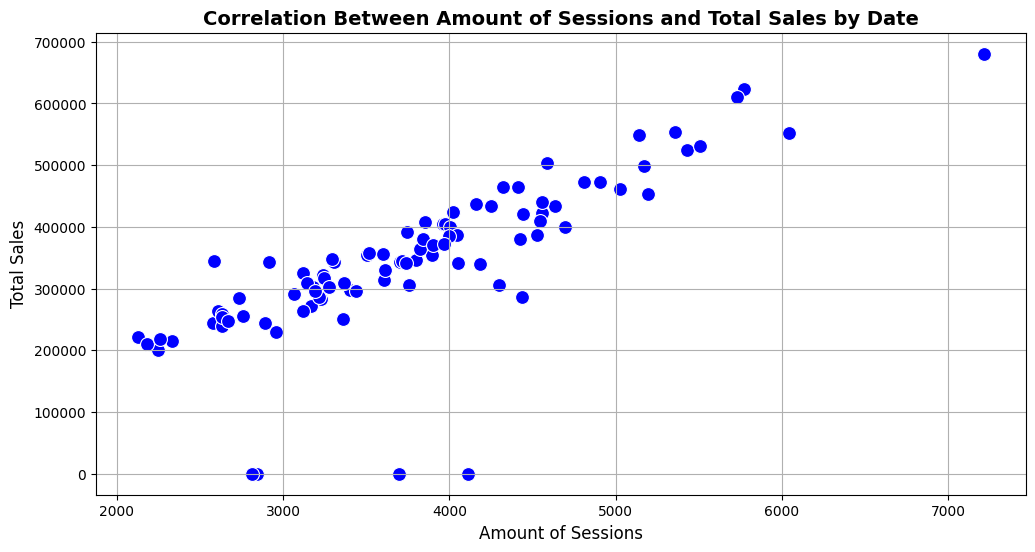

In [ ]:
import matplotlib.pyplot as plt

# Calculate total sales by date
sales_by_date = (
    order_df.groupby("order_date")["price"]
    .sum()
    .sort_index()
)

# Calculate the number of sessions by date
sessions_by_date = (
    order_df.groupby("order_date")["ga_session_id"]
    .count()
    .sort_index()
)

# Create a new DataFrame for correlation visualization
correlation_data = pd.DataFrame({
    "order_date": sales_by_date.index,
    "total_sales": sales_by_date.values,
    "amount_of_sessions": sessions_by_date.values
})

# Visualize correlation using Seaborn scatter plot
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x="amount_of_sessions",
    y="total_sales",
    data=correlation_data,
    color="blue",
    s=100
)
plt.title("Correlation Between Amount of Sessions and Total Sales by Date", fontsize=14, fontweight="bold")
plt.xlabel("Amount of Sessions", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import spearmanr
from scipy import stats
from scipy.stats import normaltest

_, p_value_normaltest_sales_date = normaltest(sales_by_date)
_, p_value_normaltest_sessions_date = normaltest(sessions_by_date)
print(f"Normal test for Sales by Date: {p_value_normaltest_sales_date}")
print(f"Normal test for Sessions by Date: {p_value_normaltest_sessions_date}")

spearman_corr = sessions_by_date.corr(sales_by_date, method="spearman")
t_stat, p_value = stats.ttest_ind(sessions_by_date, sales_by_date)

print(f"Spearman Rank: {spearman_corr}.")
if p_value < 0.05:
  print("The result is statistically significant.")
else:
  print("The result is statistically insignificant.")

Normal test for Sales by Date: 0.021085752302202193
Normal test for Sessions by Date: 0.008655428822366544
Spearman Rank: 0.8653062174563682.
The result is statistically significant.


As the normal test for both Sales by Date and Sessions by Date showed results less than 0.05, the Spearman rank has been chosen. It indicates a **strong positive correlation**.

In [ ]:
# Sum sales by continent
america_sales = (
    order_df[order_df["continent"] == "Americas"]
    .groupby("order_date")["price"]
    .sum()
)

asia_sales = (
    order_df[order_df["continent"] == "Asia"]
    .groupby("order_date")["price"]
    .sum()
)

europe_sales = (
    order_df[order_df["continent"] == "Europe"]
    .groupby("order_date")["price"]
    .sum()
)

_, p_value_normaltest_america_sales = normaltest(america_sales)
_, p_value_normaltest_asia_sales = normaltest(asia_sales)
_, p_value_normaltest_europe_sales = normaltest(europe_sales)
print(f"Normal test for Sales in America: {p_value_normaltest_america_sales}")
print(f"Normal test for Sales in Asia: {p_value_normaltest_asia_sales}")
print(f"Normal test for Sales in Europe: {p_value_normaltest_europe_sales}")

spearman_corr_america_asia = america_sales.corr(asia_sales, method="spearman")
spearman_corr_america_europe = america_sales.corr(europe_sales, method="spearman")

t_stat, p_value_america_asia = stats.ttest_ind(america_sales, asia_sales)
t_stat, p_value_america_europe = stats.ttest_ind(america_sales, europe_sales)

print(f"Spearman Rank between America and Asia: {spearman_corr_america_asia}")
print(f"Spearman Rank between America and Europe: {spearman_corr_america_europe}")

if p_value_america_asia < 0.05:
  print("The correlation between sales in America and Asia is statistically significant.")
else:
  print("The correlation between sales in America and Asia is statistically insignificant.")

if p_value_america_europe < 0.05:
  print("The correlation between sales in America and Europe is statistically significant.")
else:
  print("The correlation between sales in America and Europe is statistically insignificant.")

Normal test for Sales in America: 0.09926339704137344
Normal test for Sales in Asia: 0.20905672433615619
Normal test for Sales in Europe: 0.1310345844691827
Spearman Rank between America and Asia: 0.7099016615801969
Spearman Rank between America and Europe: 0.6725700545639509
The correlation between sales in America and Asia is statistically significant.
The correlation between sales in America and Europe is statistically significant.


Spearman Rank between both America and Asia and America and Europe indicates a moderate positive correlation.

In [ ]:
#Sort orders by cpc medium
cpc_sales = (
    order_df[order_df["medium"] == "cpc"].groupby("order_date")["price"]
    .sum()
)

#Sort orders by organic medium
organic_sales = (
    order_df[order_df["medium"] == "organic"].groupby("order_date")["price"]
    .sum()
)

#Sort orders by referral medium
referral_sales = (
    order_df[order_df["medium"] == "referral"].groupby("order_date")["price"]
    .sum()
)

_, p_value_normaltest_cpc_sales = normaltest(cpc_sales)
_, p_value_normaltest_organic_sales = normaltest(organic_sales)
_, p_value_normaltest_referral_sales = normaltest(referral_sales)
print(f"Normal test for Sales in Paid Search: {p_value_normaltest_cpc_sales}")
print(f"Normal test for Sales in Organic Search: {p_value_normaltest_organic_sales}")
print(f"Normal test for Sales in Referral: {p_value_normaltest_referral_sales}")

spearman_corr_organic_cpc = organic_sales.corr(cpc_sales, method="spearman")
spearman_corr_organic_referral = organic_sales.corr(referral_sales, method="spearman")

t_stat, p_value_organic_cpc = stats.ttest_ind(organic_sales, cpc_sales)
t_stat, p_value_organic_referral = stats.ttest_ind(organic_sales, referral_sales)

print(f"Spearman Rank between Organic Search and Paid Search: {spearman_corr_organic_cpc}")
print(f"Spearman Rank between Organic Search and Referral: {spearman_corr_organic_referral}")

if p_value_organic_cpc < 0.05:
  print("The correlation between Organic Search and Paid Search sales is statistically significant.")
else:
  print("The correlation between Organic Search and Paid Search sales is statistically insignificant.")

if p_value_organic_referral < 0.05:
  print("The correlation between Organic Search and Referral sales is statistically significant.")
else:
  print("The correlation between Organic Search and Referral sales is statistically insignificant.")

Normal test for Sales in Paid Search: 0.166195940158986
Normal test for Sales in Organic Search: 0.06864919571358095
Normal test for Sales in Referral: 0.5979512403321996
Spearman Rank between Organic Search and Paid Search: 0.4182311415271741
Spearman Rank between Organic Search and Referral: 0.7170689602022258
The correlation between Organic Search and Paid Search sales is statistically significant.
The correlation between Organic Search and Referral sales is statistically significant.


The Spearman Rank results fluctuate from a *weak* to *moderate* positive correlation.

#**Statistical Analysis of Group Differences**

In [ ]:
#Create two samples
non_registered = order_df[order_df["account_id"].isna()]
registered = order_df[order_df["account_id"].notna()]

#Aggregating sales rate by non-registered customers
sales_non_registered = (
    non_registered.groupby("order_date")["price"]
    .sum()
    .sort_index()
)

#Aggregating sales rate by registered customers
sales_registered = (
    registered.groupby("order_date")["price"]
    .sum()
    .sort_index()
)

#Check if the samples are normally distributed
_, p_value_normaltest_sales_non_registered = normaltest(sales_non_registered)
_, p_value_normaltest_sales_registered = normaltest(sales_registered)
print(f"Normal test for Non-registered Customers Sales: {p_value_normaltest_sales_non_registered}")
print(f"Normal test for Registered Customers Sales: {p_value_normaltest_sales_registered}")

#Calculate Spearman Rank
spearman_corr_sales_non_registered = sales_non_registered.corr(sales_registered, method="spearman")
t_stat, p_value_reg_non = stats.ttest_ind(sales_registered, sales_non_registered)
print(f"Spearman Rank between registered and non-registered customers sales: {spearman_corr_sales_non_registered}")

#Define statistical significance
if p_value_reg_non < 0.05:
  print("The correlation between registered and non-registered customers sales is statistically significant.")
else:
  print("The correlation between registered and non-registered customers sales is statistically insignificant.")


Normal test for Non-registered Customers Sales: 0.026362411185738954
Normal test for Registered Customers Sales: 0.010929121653065912
Spearman Rank between registered and non-registered customers sales: 0.6809728435067451
The correlation between registered and non-registered customers sales is statistically significant.


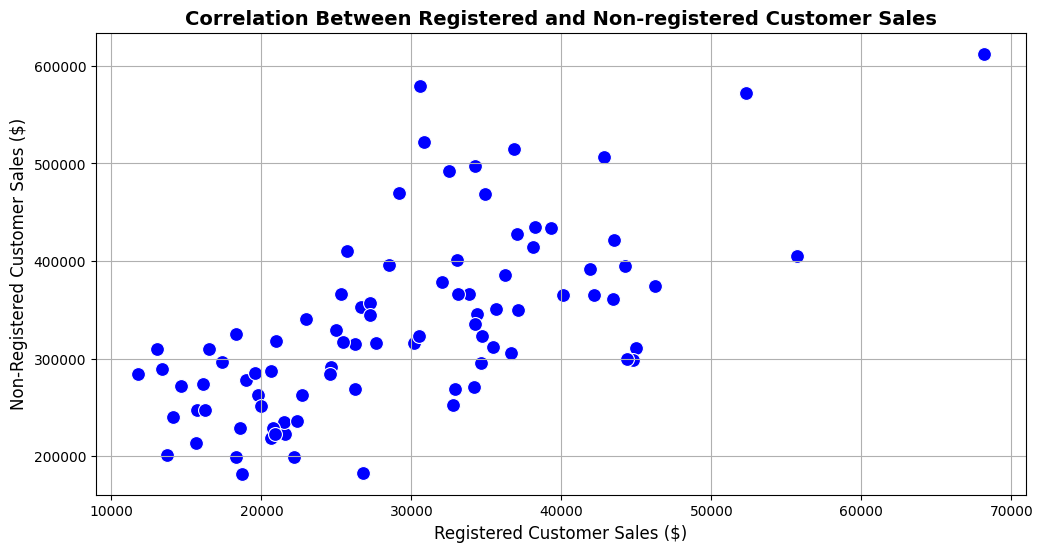

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for non-registered and registered customers
non_registered = order_df[order_df["account_id"].isna()]
registered = order_df[order_df["account_id"].notna()]

# Aggregating sales rate by non-registered customers
sales_non_registered = (
    non_registered.groupby("order_date")["price"]
    .sum()
    .sort_index()
)

# Aggregating sales rate by registered customers
sales_registered = (
    registered.groupby("order_date")["price"]
    .sum()
    .sort_index()
)

# Align the two sales Series to ensure matching indices
aligned_sales = sales_non_registered.align(sales_registered, join="inner")

# Create a new DataFrame for correlation visualization
corr_data = pd.DataFrame({
    "order_date": aligned_sales[0].index,
    "non_registered": aligned_sales[0].values,
    "registered": aligned_sales[1].values
})

# Visualize correlation using Seaborn scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x="registered",
    y="non_registered",
    data=corr_data,
    color="blue",
    s=100
)
plt.title("Correlation Between Registered and Non-registered Customer Sales", fontsize=14, fontweight="bold")
plt.xlabel("Registered Customer Sales ($)", fontsize=12)
plt.ylabel("Non-Registered Customer Sales ($)", fontsize=12)
plt.grid(True)
plt.show()


Both the Spearman Rank result and the scatter plot demonstrate a *moderate* positive correlation meaning that with the increase in the sales of registered customers the sales of non-registered customers grow too.

In [ ]:
from scipy.stats import normaltest

order_df.dropna(subset=["medium", "continent"], inplace=True)
# Create two samples
organic_europe = order_df[(order_df["medium"] == "organic") & (order_df["continent"] == "Europe")]
organic_america = order_df[(order_df["medium"] == "organic") & (order_df["continent"] == "Americas")]

# Aggregating unique sessions by desktops from Asia and Americas
sessions_europe = organic_europe["ga_session_id"].value_counts()
sessions_america = organic_america["ga_session_id"].value_counts()

# Check if the samples are normally distributed
_, p_value_normaltest_organic_europe = normaltest(sessions_europe)
_, p_value_normaltest_organic_america = normaltest(sessions_america)

print(f"Normal test for Organic Search sessions from Asia: {p_value_normaltest_organic_europe}")
print(f"Normal test for Organic Search sessions from Americas: {p_value_normaltest_organic_america}")


Normal test for Organic Search sessions from Asia: nan
Normal test for Organic Search sessions from Americas: nan


/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1580: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1776: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1580: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_stats_py.py:1776: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data 

It seems that there is not enough data to conduct this statistical experiment.

#**Tableau Visualization**

The visualization can be found [here](https://public.tableau.com/app/profile/danylo.zhyrko/viz/SessionDistributions/SessionDistributions?publish=yes).

**How Vertical Container Works**

The *Account Status* filter distinguishes registered (True) users from non-registered (False) ones.

The *Subscription Status* filter discriminates users who have subscribed (1) from those who have canceled their subscription (0).

The *Verification Status* filter distinguishes users who have verified their Email addresses (1) from those who have not (0).

#**What's Been Discovered**

The Americas, Asia, and Europe are leaders in sales and orders. The United States, India, Canada, the United Kingdom, and France are the top-rated countries.
-The demand in the US represents the general one on most required product categories.
-Most customers buy from a desktop, the most popular OS is Chrome. Organic Search gathers the biggest percentage of sales.
-More than half of users verify their emails and 83% receive electronic leaflets.
- December is the most successful month.
-Week trend shows that the peak of sales start on Tuesday and drops day by day.
- Correlation analytics shows the positive link between amount of sessions and sales rate. Whether customer is registered or not, it does not affect sales.